## Phase 4: Causality and Interpretability Summary

In Phase 4, we evaluated whether the model’s predictions reflect genuine financial causality and are interpretable. Feature importance analysis shows that the model relies on economically meaningful, event-driven textual signals such as legal actions and earnings announcements, while numerical features—especially volatility—serve as supporting context.

Market validation confirms that news classified as causal is followed by higher volatility and distinct return behavior compared to non-causal news. Statistical testing further verifies that these differences are significant.

Overall, the analysis demonstrates that the model captures real financial causality and produces transparent, economically intuitive predictions.


Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from scipy.stats import mannwhitneyu


Load Final Dataset

In [2]:
df = pd.read_csv(
    "/Users/jiveshkarthik/Documents/Visual Studio Code/Sem 8/Project NLP/Dataset_Final_Financiality_Casuality.csv"
)

TEXT_COL = "clean_text"
NUM_COLS = ["return_t1", "return_t5", "volatility_5"]
TARGET = "causal_label"

df = df.dropna(subset=[TEXT_COL] + NUM_COLS + [TARGET])

print(df.shape)
df.head()


(36672, 8)


,date,ticker,title,clean_text,return_t1,return_t5,volatility_5,causal_label
0,2018-01-24,IRS,Trump to name tax lawyer Rettig to head IRS - ...,"January 24, 2018 / 2:55 AM / Updated 12 minute...",-0.058179,-0.014003,0.038975,1
1,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1
2,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1
3,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1
4,2017-02-10,RM,RM LAW Announces Class Action Lawsuit Against ...,"BERWYN, Pa., Jan. 23, 2018 /PRNewswire/ -- RM ...",0.009906,-0.098405,0.038090,1


Load Saved Phase-3 Model

In [6]:
model = joblib.load(
    "/Users/jiveshkarthik/Documents/Visual Studio Code/Sem 8/Project NLP/final_multimodal_model.pkl"
)

print(type(model))
print(model.named_steps.keys())

<class 'sklearn.pipeline.Pipeline'>
dict_keys(['preprocessor', 'clf'])


Prediction Sanity Check

In [7]:
X = df[[TEXT_COL] + NUM_COLS]
y = df[TARGET]

y_pred = model.predict(X)

print("Prediction distribution:")
print(pd.Series(y_pred).value_counts())


Prediction distribution:
1    25916
0    10756
Name: count, dtype: int64


Global Text Feature Importance

In [8]:
# Access pipeline components
prep = model.named_steps["preprocessor"]
clf = model.named_steps["clf"]

# TF-IDF transformer
tfidf = prep.named_transformers_["text"]
feature_names = tfidf.get_feature_names_out()

# Text coefficients
text_coeffs = clf.coef_[0][:len(feature_names)]

importance_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": text_coeffs
}).sort_values(by="coefficient", ascending=False)

importance_df.head(20)


,feature,coefficient
2958,bb,2.851434
16089,rwe,2.734262
8952,hagens,2.674442
8953,hagens berman,2.674442
8412,ge,2.567283
2006,agnc,2.545683
3068,berman,2.533088
3366,bp,2.532568
19210,vici,2.428054
10068,intel,2.362668


Top Positive & Negative Drivers

In [9]:
print("Top Positive Causal Drivers")
display(importance_df.head(10))

print("\nTop Negative (Non-Causal) Drivers")
display(importance_df.tail(10))


Top Positive Causal Drivers


,feature,coefficient
2958,bb,2.851434
16089,rwe,2.734262
8952,hagens,2.674442
8953,hagens berman,2.674442
8412,ge,2.567283
2006,agnc,2.545683
3068,berman,2.533088
3366,bp,2.532568
19210,vici,2.428054
10068,intel,2.362668



Top Negative (Non-Causal) Drivers


,feature,coefficient
7121,envision,-2.055193
0,00,-2.065829
12451,motif bio,-2.131340
8565,gm,-2.214418
18857,ulta,-2.413001
18673,transwestern,-2.535352
11091,libor,-2.582639
9787,indexes,-2.622887
3103,bhp,-2.894886
19331,wageworks,-4.485076


Numerical Feature Importance

In [10]:
num_coeffs = clf.coef_[0][-len(NUM_COLS):]

num_importance = pd.DataFrame({
    "feature": NUM_COLS,
    "coefficient": num_coeffs
}).sort_values(by="coefficient", ascending=False)

num_importance


,feature,coefficient
2,volatility_5,7.340895
0,return_t1,0.447463
1,return_t5,-0.305400


Numerical Importance Plot

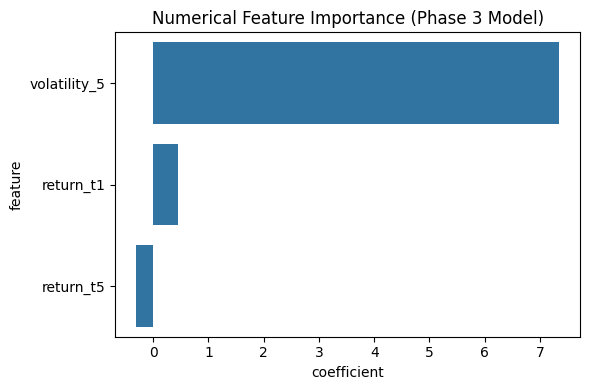

In [11]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=num_importance,
    x="coefficient",
    y="feature"
)
plt.title("Numerical Feature Importance (Phase 3 Model)")
plt.tight_layout()
plt.show()


Instance-Level Explanation

In [12]:
def explain_instance(row):
    sample = pd.DataFrame([row])
    prob = model.predict_proba(sample)[0][1]
    return prob


Example Explanation

In [22]:
# Select a specific example by index
example = df.iloc[250]

# Prepare input
sample = example[[TEXT_COL] + NUM_COLS].to_frame().T

# Get prediction and probability
pred_label = model.predict(sample)[0]
pred_prob = model.predict_proba(sample)[0][1]

# Print results
print("Headline:", example["title"])
print("Actual Label:", example[TARGET])
print("Predicted Label:", pred_label)
print("Predicted Causal Probability:", round(pred_prob, 3))


Headline: U.S. court invalidates J&J cancer drug patent, hitting UK's BTG
Actual Label: 0
Predicted Label: 0
Predicted Causal Probability: 0.016


In [23]:
# Select one true causal example (actual label = 1)
example = df[df[TARGET] == 1].iloc[0]

# Prepare input
sample = example[[TEXT_COL] + NUM_COLS].to_frame().T

# Model prediction
pred_label = model.predict(sample)[0]
pred_prob = model.predict_proba(sample)[0][1]

# Print explanation
print("Headline:", example["title"])
print("Actual Label:", example[TARGET])
print("Predicted Label:", pred_label)
print("Predicted Causal Probability:", round(pred_prob, 3))


Headline: Trump to name tax lawyer Rettig to head IRS - Politico
Actual Label: 1
Predicted Label: 1
Predicted Causal Probability: 1.0


Volatility

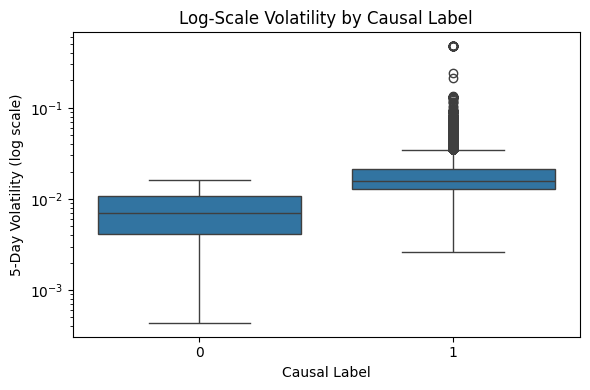

In [15]:
plt.figure(figsize=(6,4))
sns.boxplot(
    data=df,
    x="causal_label",
    y="volatility_5"
)
plt.yscale("log")
plt.title("Log-Scale Volatility by Causal Label")
plt.xlabel("Causal Label")
plt.ylabel("5-Day Volatility (log scale)")
plt.tight_layout()
plt.show()


Statistical Significance Tests

In [16]:
causal_ret = df[df[TARGET] == 1]["return_t1"]
noncausal_ret = df[df[TARGET] == 0]["return_t1"]

u_ret, p_ret = mannwhitneyu(causal_ret, noncausal_ret)
print("Mann–Whitney U p-value (returns):", p_ret)

causal_vol = df[df[TARGET] == 1]["volatility_5"]
noncausal_vol = df[df[TARGET] == 0]["volatility_5"]

u_vol, p_vol = mannwhitneyu(causal_vol, noncausal_vol)
print("Mann–Whitney U p-value (volatility):", p_vol)


Mann–Whitney U p-value (returns): 3.920196559061885e-185
Mann–Whitney U p-value (volatility): 0.0


Effect Size Summary

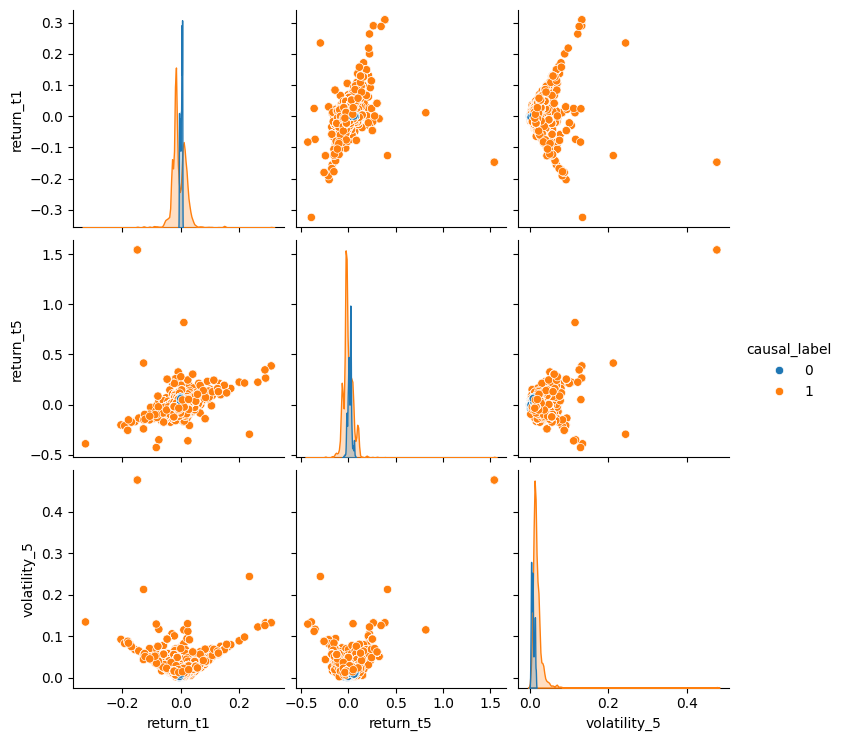

In [17]:
df.groupby("causal_label")[["return_t1", "volatility_5"]].mean()
sns.pairplot(df, hue="causal_label", vars=["return_t1", "return_t5", "volatility_5"])